# Street View House Numbers Classification

The Street View House Numbers (SVHN) dataset is one of the most popular benchmarks for object recognition tasks in academic papers. The images were obtained from house numbers in Google Street View images, are hosted by Stanford University and are very similar in philosophy with the MNIST dataset. However, the original purpose of this dataset is to solve a harder problem: that of recognizing digits and numbers in natural scene images.

The data of the Street View House Numbers dataset, which can originally be found [here](http://ufldl.stanford.edu/housenumbers) are originally in .mat, i.e. files which can be best processed with MATLAB; thus, some preprocessing is required (see section 2). It is important to note that the data are divided into two formats and in this particular kernel we are going to use **Format 2**:

- *Format 1*: The original, variable-resolution colored house-number images with character level bounding boxes.
- *Format 2*: The cropped digits (32x32 pixels) which follow the philosophy of the MNIST dataset more closely, but also contain some distracting digits to the sides of the digit of interest.

## 1. Imports

In [1]:
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
# Set random state

np.random.seed(20)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 2. Loading and preprocessing

In [ ]:
# Load the data

train_raw = loadmat('/content/drive/MyDrive/Notebooks/Datathon/data/train_32x32.mat')
test_raw = loadmat('/content/drive/MyDrive/Notebooks/Datathon/data/test_32x32.mat')

In [ ]:
# Load images and labels

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [ ]:
# Check the shape of the data

print(train_images.shape)
print(test_images.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [ ]:
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 랜덤한 인덱스 12개 선택
random_indices = np.random.choice(len(train_images), size=12, replace=False)

# 선택된 이미지와 라벨을 3행 4열의 그리드에 출력
plt.figure(figsize=(12, 9))
for i, index in enumerate(random_indices):
    plt.subplot(3, 4, i + 1)
    plt.imshow(train_images[index])
    plt.title(f"Label: {train_labels[index]}")
    plt.axis('off')
plt.show()


NameError: name 'train_images' is not defined

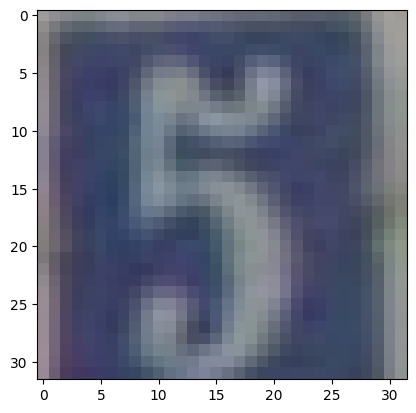

Label:  [5]


In [ ]:
# Plot a random image and its label

plt.imshow(train_images[13529])
plt.show()

print('Label: ', train_labels[13529])

In [ ]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [ ]:
# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [ ]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 0.0, Max: 255.0


In [ ]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [ ]:
# Split train data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [ ]:
y_val.shape

(10989, 10)

## 3. CNN model

In order to get more robust results out of our model, we are going to augment the images in the dataset, by randomly rotating them, zooming them in and out, shifting them up and down (**IMPORTANT NOTE:** It is best that we do not shift them horizontally, since there are also distracting digits in the images), shifting their channels and shearing them.

In [ ]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In order to determine a good learning rate for the optimizer of our model (here, we use the AMSGrad variant of the Adam optimizer), we set a callback in an auxillary model which will gradually increase the learning rate of the optimizer.

In [ ]:
# Define auxillary model

keras.backend.clear_session()

aux_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same',
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(64, (3, 3), padding='same',
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (3, 3), padding='same',
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10,  activation='softmax')
])

lr_schedule = keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = keras.optimizers.Adam(lr=1e-4, amsgrad=True)
aux_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
# Fit model in order to determine best learning rate

history = aux_model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=30, validation_data=(X_val, y_val),
                              callbacks=[lr_schedule])

<ipython-input-17-887a6e883c21>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = aux_model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),


Epoch 1/30
487/487 [==============================] - 55s 95ms/step - loss: 2.3209 - accuracy: 0.1590 - val_loss: 2.2297 - val_accuracy: 0.1947 - lr: 1.0000e-04
Epoch 2/30
487/487 [==============================] - 46s 94ms/step - loss: 2.0999 - accuracy: 0.2456 - val_loss: 1.4265 - val_accuracy: 0.5475 - lr: 1.2589e-04
Epoch 3/30
487/487 [==============================] - 43s 88ms/step - loss: 1.3153 - accuracy: 0.5582 - val_loss: 0.6761 - val_accuracy: 0.7971 - lr: 1.5849e-04
Epoch 4/30
487/487 [==============================] - 45s 92ms/step - loss: 0.8995 - accuracy: 0.7124 - val_loss: 0.4701 - val_accuracy: 0.8608 - lr: 1.9953e-04
Epoch 5/30
487/487 [==============================] - 43s 88ms/step - loss: 0.7096 - accuracy: 0.7778 - val_loss: 0.3623 - val_accuracy: 0.8921 - lr: 2.5119e-04
Epoch 6/30
487/487 [==============================] - 43s 89ms/step - loss: 0.6010 - accuracy: 0.8173 - val_loss: 0.3468 - val_accuracy: 0.8967 - lr: 3.1623e-04
Epoch 7/30
487/487 [==============

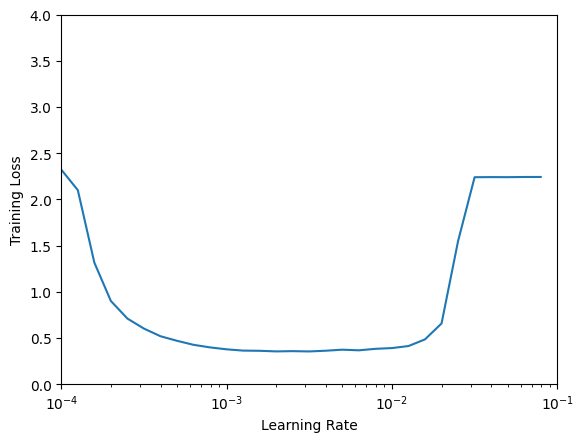

In [ ]:
# Plot Learning Rate vs. Loss

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1e-1, 0, 4])
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.show()

We can see that the loss follows a very specific trajectory: a rapid drop followed by a relatively flat line which shoots back up after a certain point. Thus, it is better to choose a learning rate in the region where the loss is stable; a reasonable choice would be **lr = 0.01** (or 1e-3).

In [ ]:
# Define actual model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same',
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(64, (3, 3), padding='same',
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (3, 3), padding='same',
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/kaggle/working/best_cnn.h5',
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

In [ ]:
# Fit model in order to make predictions

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70


<ipython-input-21-944d98061737>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),


487/487 [==============================] - 46s 88ms/step - loss: 2.2106 - accuracy: 0.1889 - val_loss: 1.8862 - val_accuracy: 0.3085


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/70
487/487 [==============================] - 43s 89ms/step - loss: 1.8001 - accuracy: 0.3184 - val_loss: 1.1910 - val_accuracy: 0.5746
Epoch 3/70
487/487 [==============================] - 43s 89ms/step - loss: 1.0574 - accuracy: 0.6320 - val_loss: 0.4430 - val_accuracy: 0.8740
Epoch 4/70
487/487 [==============================] - 42s 87ms/step - loss: 0.5622 - accuracy: 0.8343 - val_loss: 0.3080 - val_accuracy: 0.9152
Epoch 5/70
487/487 [==============================] - 42s 86ms/step - loss: 0.4374 - accuracy: 0.8721 - val_loss: 0.2664 - val_accuracy: 0.9261
Epoch 6/70
487/487 [==============================] - 44s 90ms/step - loss: 0.3895 - accuracy: 0.8889 - val_loss: 0.2541 - val_accuracy: 0.9334
Epoch 7/70
487/487 [==============================] - 42s 86ms/step - loss: 0.3519 - accuracy: 0.9003 - val_loss: 0.2337 - val_accuracy: 0.9352
Epoch 8/70
487/487 [==============================] - 42s 87ms/step - loss: 0.3311 - accuracy: 0.9063 - val_loss: 0.2308 - val_accuracy:

In [ ]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

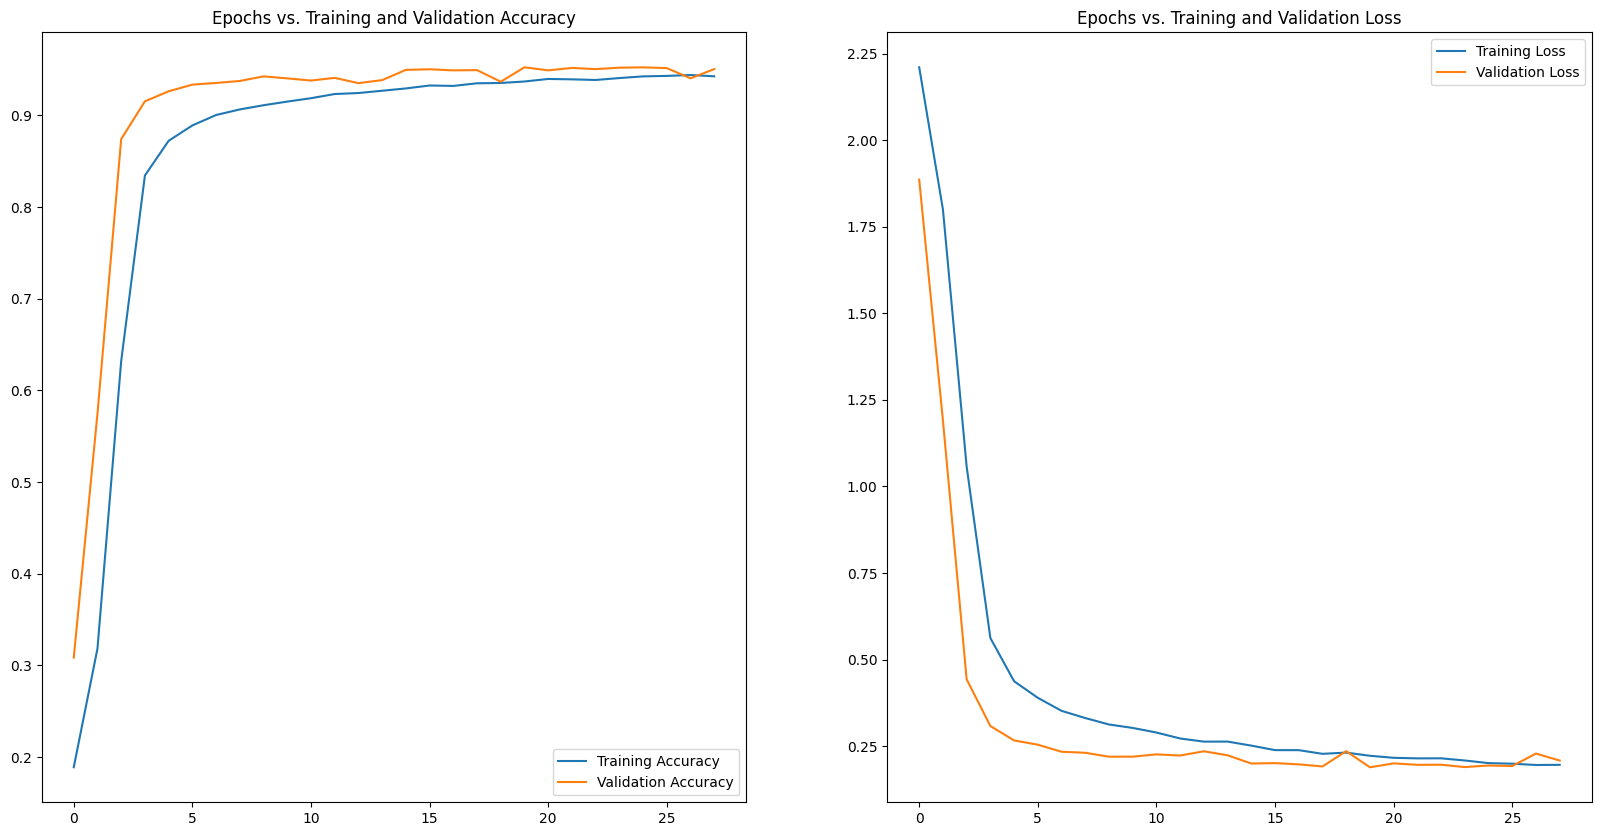

In [ ]:
# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

After seeing how the algorithm converged, we can now evaluate the model's performance on the test data.

In [ ]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9556 
Test loss is: 0.1828


In [ ]:
# 모델 저장
model.save("/content/drive/MyDrive/Notebooks/Datathon/CNN_acc_96_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
from sklearn.preprocessing import LabelBinarizer

def evaluate_model(X_test, y_test, model_path):
    # 모델 로드
    model = load_model(model_path)

    # 모델 평가
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"테스트 데이터의 정확도: {accuracy}")

    # 테스트 이미지에 대한 예측 결과 출력
    num_images = len(X_test)
    num_rows = (num_images + 7) // 8  # 2x4 그리드로 변경 => 올림 연산을 사용하여 행의 수 계산

    for i in range(num_rows):
        plt.figure(figsize=(15, 10))
        for j in range(4):
            index = i * 4 + j
            if index < num_images:
                # 이미지 예측
                prediction = model.predict(np.array([X_test[index]]))  # 이미지에 대한
                predicted_label = np.argmax(prediction)   # 각 값에 대한 최대값을 출력

                # 이미지와 레이블 출력
                # 모델이 예측한 값과 이미지 라벨이 맞는지 출력
                plt.subplot(2, 4, j + 1)
                plt.imshow(X_test[index])
                plt.title(f"Predicted Label: {predicted_label}, True Label: {y_test[index]}")
                plt.axis('off')
        plt.show()

# 모델 경로
model_path = "/content/drive/MyDrive/Notebooks/Datathon/all_model.h5"

# 테스트 데이터 경로
test_raw = loadmat('/content/drive/MyDrive/Notebooks/Datathon/data/test_32x32.mat')
test_images = np.moveaxis(test_raw['X'], -1, 0)
test_labels = test_raw['y'].flatten()

# Normalize the images data
test_images = test_images.astype('float64') / 255.0

# One-hot encoding of test labels
lb = LabelBinarizer()
test_labels = lb.fit_transform(test_labels)

# 모델 평가
evaluate_model(test_images, test_labels, model_path)


NameError: name 'loadmat' is not defined

In [ ]:
## 새로운 테스트 이미지 전처리
import os
import pandas as pd
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

def preprocess_images(csv_file, image_dir):
    # CSV 파일 읽기
    df = pd.read_csv(csv_file)

    # 이미지와 레이블을 저장할 리스트 초기화
    images = []
    labels = []

    # 각 이미지 파일에 대한 처리
    for index, row in df.iterrows():
        # 이미지 파일 경로
        image_path = os.path.join(image_dir, row['filename'])

        # 이미지 불러오기
        image = cv2.imread(image_path)

        # 숫자가 있는 영역 자르기
        left, top, width, height = row['left'], row['top'], row['width'], row['height']
        digit_image = image[top:top+height, left:left+width].copy()  # 원본 이미지에 영향을 주지 않도록 복사

        # 이미지 크기 조정 및 정규화
        digit_image = cv2.resize(digit_image, (32, 32))
        digit_image = digit_image.astype('float32') / 255.0

        # 이미지와 레이블 추가
        images.append(digit_image)
        labels.append(row['label'])

    # 리스트를 넘파이 배열로 변환
    X_test = np.array(images)
    y_test = np.array(labels)

    print("전처리가 완료되었습니다.")

    return X_test, y_test


In [ ]:
def evaluate_model(X_test, y_test, model_path):
    # 모델 로드
    model = load_model(model_path)

    # 레이블을 원-핫 인코딩
    y_test_encoded = to_categorical(y_test, num_classes=10)

    # 모델 평가
    loss, accuracy = model.evaluate(X_test, y_test_encoded)
    print(f"테스트 데이터의 정확도: {accuracy}")

    # 테스트 이미지에 대한 예측 결과 출력
    num_images = len(X_test)
    num_rows = (num_images + 11) // 12  # 올림 연산을 사용하여 행의 수 계산 => 12개씩 출력을 위해

    for i in range(num_rows):
        plt.figure(figsize=(15, 10))
        for j in range(12):
            index = i * 12 + j
            if index < num_images:
                # 이미지 예측
                prediction = model.predict(np.array([X_test[index]]))  # 이미지에 대한
                predicted_label = np.argmax(prediction)   # 각 값에 대한 최대값을 출력

                # 이미지와 레이블 출력
                # 모델이 예측한 값과 이미지 라벨이 맞는지 출력
                plt.subplot(3, 4, j + 1)
                plt.imshow(X_test[index])
                plt.title(f"Predicted Label: {predicted_label}, True Label: {y_test[index]}")
                plt.axis('off')
        plt.show()

In [3]:
# CSV 파일이 있는 디렉토리 경로
csv_dir = "/content/drive/MyDrive/Notebooks/Datathon/datathon_test_image"

# 이미지 파일이 있는 디렉토리 경로
image_dir = "/content/drive/MyDrive/Notebooks/Datathon/datathon_test_image"

# CSV 파일 경로
csv_file = os.path.join(csv_dir, "data.csv")

# 전처리된 테스트 이미지 데이터 및 레이블 가져오기
X_test, y_test = preprocess_images(csv_file, image_dir)

# 모델 경로
model_path = "/content/drive/MyDrive/Notebooks/Datathon/all_model.h5"

# 모델 평가
evaluate_model(X_test, y_test, model_path)

NameError: name 'os' is not defined

In [4]:
# CSV 파일이 있는 디렉토리 경로
csv_dir = "/content/drive/MyDrive/Notebooks/Datathon/datathon_test_image"

# 이미지 파일이 있는 디렉토리 경로
image_dir = "/content/drive/MyDrive/Notebooks/Datathon/datathon_test_image"

# CSV 파일 경로
csv_file = os.path.join(csv_dir, "data.csv")

# 전처리된 테스트 이미지 데이터 및 레이블 가져오기
X_test, y_test = preprocess_images(csv_file, image_dir)

# 모델 경로
model_path = "/content/drive/MyDrive/Notebooks/Datathon/my_model.h5"

# 모델 평가
evaluate_model(X_test, y_test, model_path)

NameError: name 'os' is not defined

In [5]:
# 최종평가
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    # 이미지 불러오기
    image = cv2.imread(image_path)

    # 이미지 크기 조정 및 정규화
    resized_image = cv2.resize(image, (32, 32))
    resized_image = resized_image.astype('float32') / 255.0

    return resized_image

def evaluate_model(model_path, test_data_dir):
    # 모델 로드
    model = load_model(model_path)

    # 테스트 데이터 경로
    test_data_paths = [os.path.join(test_data_dir, f"testdata{i}.png") for i in range(1, 24165)]

    # 테스트 이미지에 대한 예측 결과 출력
    num_images = len(test_data_paths)
    num_rows = (num_images + 11) // 12  # 올림 연산을 사용하여 행의 수 계산 => 12개씩 출력을 위해

    correct_predictions = 0  # 정확한 예측 수 초기화

    accuracy = correct_predictions / num_images
    print(f"테스트 데이터의 정확도 : {accuracy}")

    for i in range(num_rows):
        plt.figure(figsize=(15, 10))
        for j in range(12):
            index = i * 12 + j
            if index < num_images:
                # 이미지 전처리
                preprocessed_image = preprocess_image(test_data_paths[index])

                # 이미지 예측
                prediction = model.predict(np.array([preprocessed_image]))
                predicted_label = np.argmax(prediction)

                # 이미지와 레이블 출력
                plt.subplot(3, 4, j + 1)
                plt.imshow(preprocessed_image)
                plt.title(f"Predicted Label: {predicted_label}")
                plt.axis('off')

                # 정답인 경우 정확한 예측 수 증가
                if predicted_label == index + 1:
                    correct_predictions += 1
        plt.show()


# 모델 경로
model_path = "/content/drive/MyDrive/Notebooks/Datathon/all_model.h5"

# 테스트 데이터 경로
test_data_dir = "/content/drive/MyDrive/Notebooks/Datathon/data/TestData"

# 모델 평가
evaluate_model(model_path, test_data_dir)


ModuleNotFoundError: No module named 'cv2'

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import pandas as pd

def preprocess_image(image_path):
    # 이미지 불러오기
    image = cv2.imread(image_path)

    # 이미지 크기 조정 및 정규화
    resized_image = cv2.resize(image, (32, 32))
    resized_image = resized_image.astype('float32') / 255.0

    return resized_image

def evaluate_model(model_path, test_data_dir):
    # 모델 로드
    model = load_model(model_path)

    # 테스트 데이터 경로
    test_data_paths = [os.path.join(test_data_dir, f"testdata{i}.png") for i in range(1, 24165)]

    # 예측 결과와 파일 이름을 저장할 리스트 초기화
    predicted_labels = []
    file_names = []

    for i, image_path in enumerate(test_data_paths):
        # 이미지 전처리
        preprocessed_image = preprocess_image(image_path)

        # 이미지 예측
        prediction = model.predict(np.array([preprocessed_image]))
        predicted_label = np.argmax(prediction)

        # 예측 결과와 파일 이름을 리스트에 추가
        predicted_labels.append(predicted_label)
        file_names.append(os.path.basename(image_path))

    # 예측 결과와 파일 이름을 DataFrame으로 변환
    df = pd.DataFrame({'filename': file_names, 'label': predicted_labels})

    # CSV 파일로 저장
    output_csv_path = "/content/drive/MyDrive/Notebooks/Datathon/predictions.csv"
    df.to_csv(output_csv_path, index=False)

    print("예측 결과를 CSV 파일로 저장했습니다.")

# 모델 경로
model_path = "/content/drive/MyDrive/Notebooks/Datathon/all_model.h5"

# 테스트 데이터 경로
test_data_dir = "/content/drive/MyDrive/Notebooks/Datathon/data/TestData"

# 모델 평가 및 결과 저장
evaluate_model(model_path, test_data_dir)


KeyboardInterrupt: 

Not bad at all! This result implies that our error ranges from ~4% to ~4.4% and we should have in mind that the errors reported by state-of-the-art models and methods range from 4.9% to 1.02% ([reference](https://benchmarks.ai/svhn)). Of course, there is room for quite a bit of tuning in order to improve performance such as:
- Change the way the images are transformed in the augmentation process.
- Change the architecture of our model by adding extra blocks, changing the kernel sizes, making it deeper, etc.
- Train multiple CNNs and make ensemble predictions.
- Use some of the extra data which can be found along with the original dataset.

## 4. Visualizations and insights

In this section, we can present some nice and useful visualizations which make us understand better how our Convolutional Neural Network actually works. It is my belief that the two following visualizations are the most helpful:

- The **Confusion Matrix** of the model on the training data, so as to get a sense of how it performs on each class label and how the misclassifications are distributed.
- The **Feature Maps** for a random input image, so as to get a sense of how our model learns the features in each convolutional layer.

In [ ]:
# Get predictions and apply inverse transformation to the labels

y_pred = model.predict(X_train)

y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)

1946/1946 [==============================] - 9s 5ms/step


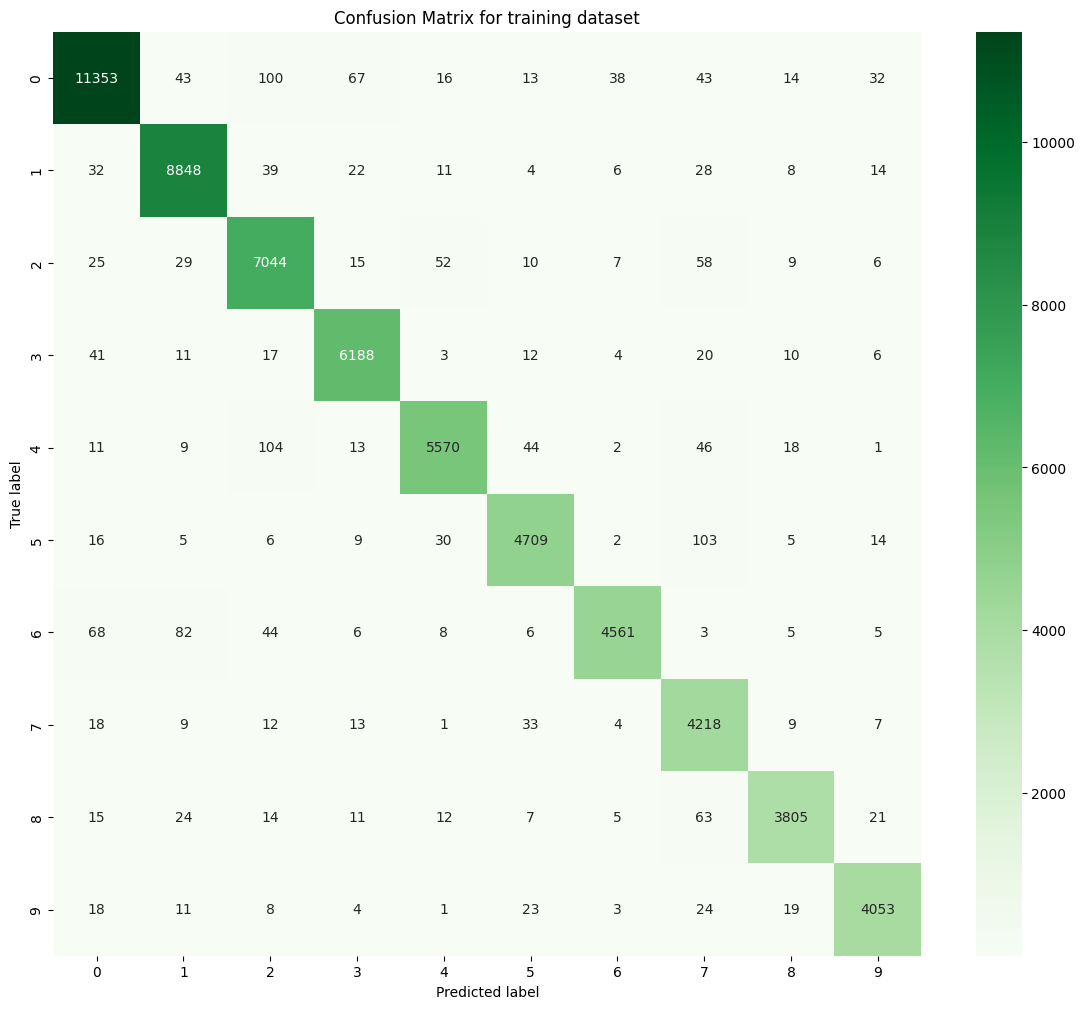

In [ ]:
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

As we can see, the training data consists mostly of 0s, 1s and 2s (in a descending order), while labels '5' up to '9' are underepresented. Furthermore, the confusion matrix can show us the particular problematic cases of our model.

## 5. Conclusion

In this kernel, we have trained a Convolutional Neural Network to recognize the digits in the Street View House Numbers dataset (Format 2). In particular, we have performed some minimal preprocessing of the data, we have augmented the data in various ways, we have created an auxillary model in order to find which learning rate we should choose for our optimizer and finally, we have trained the final CNN and evaluated it on the test images data. Furthermore, we have provided two useful visualizations (confusion matrix and feature maps) so as get a sense of how our model actually works and not view it as just a black-box process. Finally, it should be noted that there is quite a bit of room for tuning and different architectures so as to improve the accuracy of the model; nonetheless, our results are pretty good given the simplicity of our approach.

I hope you enjoyed this simple kernel and find it useful, either as a reference for your own projects or as an introduction to the complete process of training CNNs. Also, **PLEASE DO NOT FORGET TO UPVOTE!**